In [50]:
# Setup
import pattern.web as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from cs109style import customize_mpl, customize_css
customize_mpl()
customize_css()
%pylab inline

Setting custom matplotlib visual style
Setting custom CSS for the IPython Notebook
Populating the interactive namespace from numpy and matplotlib


## Example 2: extracting reddit titles, upvotes, downvotes, and submission time

### We'll operate in two phases:
* first, find all the URLs to comment pages on the first few front pages of reddit.
* second, extract information from each comments page

In [9]:
def get_links_from_front_pages(n):
    'find  URLs of comments pages, linked from the n first few pages of reddit'
    url = web.URL('http://www.reddit.com/')
    dom = url.download(cached=False)
    comment_pages = []
    for page_idx in range(n):
        dom = web.DOM(url.download(cached=False))
        links = [li.by_tag("a") for li in dom.by_tag("li.first")]
        comment_pages += [link[0].attributes.get('href','') for link in links] 
        ### Extract comments pages
        
        ### find the next page link - reddit has 25 links per page
        for a in dom('a'):
            if 'count=%d' % ((page_idx + 1)*25) in a.attributes.get('href',''):
                url = web.URL(a.attributes.get('href',''))
        
    # use set() to remove repeated URLs
    return list(set(comment_pages))

print len(get_links_from_front_pages(6))

184


In [83]:
def info_from_comments_pages(links):
    'fetch title, upvotes, downvotes, time of submission from a sequence of links'
    results = []
    for urltext in links:
        url = web.URL(urltext)
        print "fetching info for", url
        try:
            dom = web.DOM(url.download(cached=False))
            ### Extract title, upvotes, downvotes, submission time
            title = dom('title')[0].content
            score = dom.by_class('score')[0]
            
            points = float(score.by_class('number')[0].content.replace(',',''))
            m = re.search("([0-9]{1,3})\% upvoted", score.content)
            upPercent = float(m.group(1))
            totalvotes = 100.*points/(2*upPercent - 100.)
            upvotes = totalvotes*upPercent/100.
            downvotes = totalvotes - upvotes
            
            time = dom.by_class('tagline')[0]('time')[0].attributes.get('datetime')
            results.append((title, upvotes, downvotes, pd.to_datetime(time)))
        except KeyboardInterrupt:
            # allow us to interrupt the kernel and still continue
            break
        except:
            print 'Can\'t find info'
            pass  # some things that look like comment pages don't have the information above
    return results

In [12]:
comments_pages = get_links_from_front_pages(5)

In [80]:
comments_pages = comments_pages[:20]
print "Fetching info for", len(comments_pages), "pages"
pages = info_from_comments_pages(comments_pages)

Fetching info for 20 pages
fetching info for https://www.reddit.com/r/AskReddit/comments/4bqpy8/what_do_you_consider_to_be_the_best_arcade_game/
fetching info for https://www.reddit.com/r/pics/comments/4bpjkh/thanks_indeed_mr_pipe/
fetching info for https://www.reddit.com/r/GetMotivated/comments/4bmfot/imagemy_sons_fortune_cookie_motivation_for_any/
fetching info for https://www.reddit.com/r/videos/comments/4bopv0/bow_and_arrow_primitive_technology/
fetching info for https://www.reddit.com/r/WritingPrompts/comments/4boqu6/wp_your_roommate_is_2nd_most_powerful_superhero/
fetching info for https://www.reddit.com/r/sports/comments/4bnqzd/amazing_skateboarding_skill_xpost_rbeamazed/
fetching info for https://www.reddit.com/r/listentothis/comments/4bme3d/strawberry_girls_simon_vandetta_progpostrock/
fetching info for https://www.reddit.com/r/news/comments/4bnyt2/colleges_slammed_with_lawsuits_from_men_accused/
fetching info for https://www.reddit.com/r/funny/comments/4bqq9d/dont_talk_to_me_

In [81]:
print pages
titles, upvotes, downvotes, dates = zip(*pages)  # zip(*seq) transposes a sequence of sequences.
df = pd.DataFrame({'title' : titles, 'upvotes' : upvotes, 'downvotes' : downvotes, 'date' : dates}, index=dates)
print df

[(u'What do you consider to be the best arcade game ever? : AskReddit', 4.9411764705882355, 0.9411764705882355, Timestamp('2016-03-24 07:55:36')), (u'Thanks indeed, Mr. Pipe. : pics', 6010.439024390244, 594.4390243902435, Timestamp('2016-03-24 01:17:36')), (u"[Image]My son's fortune cookie \u2014 motivation for any age imo. : GetMotivated", 3103.714285714286, 547.7142857142858, Timestamp('2016-03-23 13:24:19')), (u'Bow and Arrow (Primitive Technology) : videos', 6310.761904761905, 548.7619047619046, Timestamp('2016-03-23 21:59:04')), (u'[WP] Your roommate is 2nd most powerful superhero in the world and he will not shut up about it. He does not yet know that you are the 1st. : WritingPrompts', 1061.9302325581396, 79.93023255813955, Timestamp('2016-03-23 22:05:12')), (u'Amazing skateboarding skill (x-post /r/BeAmazed) : sports', 4051.7820512820513, 500.78205128205127, Timestamp('2016-03-23 18:25:42')), (u'strawberry girls -- simon vandetta [prog/post-rock, experimental] (2015) l2t best o

C:\Users\rlochavillo\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


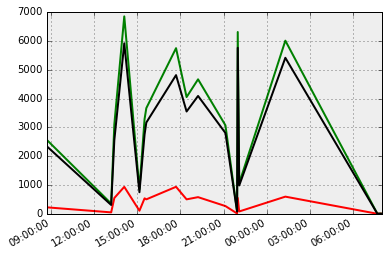

In [82]:
df.sort('date', inplace=True)
df['upvotes'].plot(c='g')
df['downvotes'].plot(c='r')
(df['upvotes'] - df['downvotes']).plot(c='k')
